### Import libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import Model, Input, optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU, concatenate
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

pd.options.mode.chained_assignment = None

### Load data

In [25]:
df = pd.read_csv(r'data_extracted.csv')
df.head()

,Unnamed: 0,HADM_ID,SUBJECT_ID,NUMBER_OF_PROCEDURES,NUMBER_OF_DIAGNOSIS,LENGTH_OF_STAY,ICU_LOS,TEXT,MARRIED,DIVORCED,SINGLE,SEPARATED,WIDOWED,UNKNOWN (DEFAULT),LIFE PARTNER
0,0,100009,533,4,144,4,2.4908,grafting cardiac catheterization date 2162 5 1...,1,0,0,0,0,0,0
1,1,100012,60039,4,165,10,3.5763,6 mchc 36 6 rdw 13 5 2177 3 12 04 05pm hba1c 5...,1,0,0,0,0,0,0
2,2,100028,53456,5,99,6,2.0321,bolus lr bp improved 90 100 given ivf needed m...,0,0,1,0,0,0,0
3,3,100034,51495,3,88,3,1.1599,1 diuresed towards preoperative weight pod 1 t...,1,0,0,0,0,0,0
4,4,100037,58947,13,6846,46,1.8369,73 p 83 r 20 o2 975 ra general alert oriented ...,1,0,0,0,0,0,0


### Text and Numeric data

In [26]:
text_input = df["TEXT"].values
numeric_input = df[["NUMBER_OF_PROCEDURES", "NUMBER_OF_DIAGNOSIS",\
                    "ICU_LOS", "MARRIED", "DIVORCED", "SINGLE", "SEPARATED",\
                    "WIDOWED", "UNKNOWN (DEFAULT)","LIFE PARTNER"]]
print(text_input[0])
numeric_input.values

grafting cardiac catheterization date 2162 5 11 place mwmc lad chronic total occlusion proximally distal filling via collaterals rca chronic total occlusion non dominant rca 90 lcx new complex 90 stenosis prox lcx involving bifurcation lcx proper large om2 old stent lcx widely patent mod lv systolic dysfx anterior apical infero apical ak reduced ef 30 lvedp 36mmhg valvular dz past medical history cad ami 2143 7 3 name prefix prefixes last name prefixes lcx 6 2155 cardiomyopathy ef 35 45 depending study ventricular tachycardia p aicd 8 2155 atrial flutter p ablation 8 2155 hypertension dyslipidemia insulin dependent diabetes mellitus obesity conduction disease lafb peripheral vascular disease p right fem doctor last name bypas 3 2161 left leg claudication right thigh tumor p radiation excision 2141 social history race caucasian last dental exam lives wife occupation name2 ni 56028 owns company tobacco 2ppd x20 yrs quit 2143 etoh occaisional family history father died 50yo cirrhosis moth

array([[  4.    , 144.    ,   2.4908, ...,   0.    ,   0.    ,   0.    ],
       [  4.    , 165.    ,   3.5763, ...,   0.    ,   0.    ,   0.    ],
       [  5.    ,  99.    ,   2.0321, ...,   0.    ,   0.    ,   0.    ],
       ...,
       [  2.    ,  52.    ,   2.0489, ...,   1.    ,   0.    ,   0.    ],
       [  4.    , 261.    ,   6.9597, ...,   0.    ,   0.    ,   0.    ],
       [  3.    , 192.    ,   1.0623, ...,   0.    ,   0.    ,   0.    ]])

### Tokenize the text data

In [27]:
max_sequence = 300
max_words = 50000
X = text_input
tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen = max_sequence)
X

array([[  815,    76,   349, ...,   125,   527,   642],
       [   14,   126,   557, ...,    71,   132,   322],
       [ 1987,  7137,   310, ...,    35,   200,  2350],
       ...,
       [  415,   233,     1, ...,    27,     1,  1578],
       [ 1025,  1585,     8, ...,    22,   228, 40130],
       [   78,     3,    24, ...,  1185,     2,    65]])

### Input and Output Arrays

In [28]:
x = X                 # text input   (  , 250)                    
z = numeric_input.values     # numeric inpute(  , 10)
y = df["LENGTH_OF_STAY"].values

print(x.shape,y.shape,z.shape)

(10767, 300) (10767,) (10767, 10)


### Exploratory analysis

Output (Length of stay):
 Mean : 9.338720163462432, Median : 7.0, Max : 169, Min : 0, Range: 169 

NUMBER_OF_PROCEDURES:
Mean : 4.729265347822049, Median : 4.0, Max : 40.0, Min : 1.0, Range: 39.0 

NUMBER_OF_DIAGNOSIS:
Mean : 354.79752948825114, Median : 150.0, Max : 56400.0, Min : 4.0, Range: 56396.0 

ICU_LOS:
Mean : 3.0841625801058785, Median : 2.0546, Max : 169.4202, Min : 0.0001, Range: 169.4201 

MARRIED:
Mean : 0.5968236277514628, Median : 1.0, Max : 1.0, Min : 0.0, Range: 1.0 

DIVORCED:
Mean : 0.060183895235441626, Median : 0.0, Max : 1.0, Min : 0.0, Range: 1.0 

SINGLE:
Mean : 0.21714498003157798, Median : 0.0, Max : 1.0, Min : 0.0, Range: 1.0 

SEPARATED:
Mean : 0.012445435125847497, Median : 0.0, Max : 1.0, Min : 0.0, Range: 1.0 

WIDOWED:
Mean : 0.10977988297575926, Median : 0.0, Max : 1.0, Min : 0.0, Range: 1.0 

UNKNOWN (DEFAULT):
Mean : 0.003436426116838488, Median : 0.0, Max : 1.0, Min : 0.0, Range: 1.0 

LIFE PARTNER:
Mean : 0.0001857527630723507, Median : 0.0, Max : 

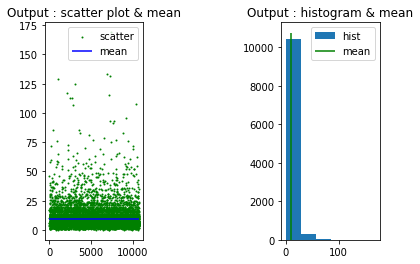

In [29]:
print('Output (Length of stay):\n','Mean : {}, Median : {}, Max : {}, Min : {}, Range: {}'\
      .format(np.mean(y), np.median(y), np.max(y), np.min(y), np.max(y) - np.min(y)), '\n')
for i in range(z.shape[1]):
    print('{}:'.format(numeric_input.columns[i]))
    print('Mean : {}, Median : {}, Max : {}, Min : {}, Range: {}'\
          .format(np.mean(z[:,i]), np.median(z[:,i]), np.max(z[:,i]), np.min(z[:,i]), \
                  np.max(z[:,i]) - np.min(z[:,i])), '\n')
plt.subplot(1,3,1)
plt.scatter(range(len(y)), y, s= 1, color = 'g', label = 'scatter')
plt.hlines(y = np.mean(y), xmin = 0, xmax = len(y), colors = 'b', label = 'mean')
plt.title('Output : scatter plot & mean'), plt.legend(loc = 1)
plt.subplot(1,3,3)
plt.hist(y, bins = 6, label = 'hist')
plt.vlines(x = np.mean(y), ymin = 0, ymax = len(y), colors = 'g', label = 'mean')
plt.title('Output : histogram & mean'), plt.legend(loc = 1)
plt.show()

### Train/Test Split

In [30]:
test_size = 0.2
x_train, x_test, z_train, z_test, y_train, y_test = train_test_split(x,z,y, test_size = test_size, random_state = 0)
print('\nNumber of training data:',x_train.shape[0])
print('\nNumber of text data:',x_test.shape[0])
z_train.shape


Number of training data: 8613

Number of text data: 2154


(8613, 10)

### Model structure

#### Linear Regression Models

In [ ]:
lr = LinearRegression()

yhat_cv = cross_val_predict(lr, z_train, y_train, cv = 4)
yhat_cv_text = cross_val_predict(lr, x_train, y_train, cv = 4)

score_cv = cross_val_score(lr, z_train, y_train, cv = 4)
score_cv_text = cross_val_score(lr, x_train, y_train, cv = 4)

R2 = r2_score(y_train, yhat_cv)
MSE = mean_squared_error(y_train, yhat_cv)
MSE_text = mean_squared_error(y_train, yhat_cv_text)

lr.fit(z_train, y_train)
yhat_train = lr.predict(z_train)
score_train = lr.score(z_train, y_train)
print('\nLinear regression training score (R squared) of numeric data ( , 10) is',score_train)

lr.fit(x_train, y_train)
yhat_train_text = lr.predict(x_train)
score_train_text = lr.score(x_train, y_train)
print('\nLinear regression training score (R squared) of text data ( , 250) is', score_train_text)

#### Polynomial linear regression

In [ ]:
pf = PolynomialFeatures(degree = 2)
z_train_poly = pf.fit_transform(z_train)
z_test_poly = pf.fit_transform(z_test)

x_train_poly = pf.fit_transform(x_train)
x_test_poly = pf.fit_transform(x_test)

poly_num = LinearRegression()
poly_num.fit(z_train_poly, y_train)
yhat_poly_num = poly_num.predict(z_train_poly)

poly_text = LinearRegression()
poly_text.fit(x_train_poly, y_train)
yhat_poly_text = poly_text.predict(x_train_poly)

print('Numeric:')
print('\nNumeric: R squared error for polynomial regression is:',poly_num.score(z_train_poly, y_train))
print('Actual output:', y_train[:5])
print('\nPredicted output:', yhat_poly_num[:5])
print('\nText:')
print('\nR squared error for polynomial regression is:',poly_text.score(x_train_poly, y_train))
print('Actual output:', y_train[:5])
print('\nPredicted output:', yhat_poly_text[:5])

In [ ]:
z_train_poly.shape

#### DNN : Numeric data only

In [ ]:
m_num = Sequential() 
num_input = Input(shape = (10, ))
numl = Dense(512, activation = 'linear')(num_input)
d1 = Dropout(0.2)(numl)
numl2 = Dense(256, activation = 'relu')(d1)
d2 = Dropout(0.2)(numl2)
numl3 = Dense(128, activation = 'relu')(d2)
d3 = Dropout(0.2)(numl3)
numl4 = Dense(64, activation = 'relu')(d3)
d4 = Dropout(0.2)(numl4)
output = Dense(1, activation = "linear")(d4)
m_num = Model(inputs = num_input, outputs = output)
m_num.summary()

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=5)
adam = optimizers.Adam(lr = 0.00001)
m_num.compile(optimizer = adam, loss = 'mae', metrics=['mse', 'mae'])

'''fit the model with 20% validation'''
m_num_history = m_num.fit(z_train, y_train, batch_size=100, epochs=10, validation_split = 0.2, callbacks = [callback])

In [ ]:
yhat_train_num = m_num.predict(z_train)
yhat_test_num = m_num.predict(z_test)
plt.scatter(z_train[:,1], y_train, s = 5 , color = 'g', label = 'actual')
plt.scatter(z_train[:,1], yhat_train_num, s=5, color = 'b', label ='predicted')
plt.legend(loc = 1)
print('\nRsquared score on train is:',r2_score(y_train, yhat_train_num))
print('\nRsquared score on test is:',r2_score(y_test, yhat_test_num))
print('\nActual output:\n', y_train[:5])
print('\nPredicted output:\n', yhat_train_num[:5])
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(range(len(m_num_history.history['val_loss'])),m_num_history.history['val_loss'],'-o', label = 'val_loss')
plt.plot(range(len(m_num_history.history['loss'])),m_num_history.history['loss'],'-o', label = 'train_loss')
plt.legend(loc = 1, fontsize = 10)
plt.ylabel('MSE'), plt.title('DNN: Numeric data')
plt.subplot(2,1,2)
plt.plot(range(len(m_num_history.history['val_mae'])),m_num_history.history['val_mae'],'-o', label = 'validation MAE')
plt.plot(range(len(m_num_history.history['mae'])),m_num_history.history['mae'],'-o', label = 'train MAE')
plt.legend(loc = 1, fontsize = 10)
plt.ylabel('MAE')
plt.show()

#### DNN : Text only

In [114]:
m_text = Sequential() 
text_input = Input(shape = (300, ))
numl = Dense(1000, activation = 'softmax')(text_input)
d1 = Dropout(0.4)(numl)
numl2 = Dense(500, activation = 'relu')(d1)
d2 = Dropout(0.4)(numl2)
numl3 = Dense(100, activation = 'relu')(d2)
d3 = Dropout(0.3)(numl3)
output = Dense(1, activation = "linear")(d3)
m_text = Model(inputs = text_input, outputs = output)
# m_text.summary()

#### Train the model

In [115]:
callback = EarlyStopping(monitor='val_loss', patience=5)
adam = optimizers.Adam(lr = 0.1)
m_text.compile(optimizer = adam, loss = 'mse', metrics=['mse', 'mae'])

'''fit the model with 20% validation'''
m_text_history = m_text.fit(x_train, y_train, batch_size=100, epochs=100, validation_split = 0.2, callbacks = [callback])

Train on 6890 samples, validate on 1723 samples
Epoch 1/100
6890/6890 [==============================] - 3s 368us/step - loss: 140.1977 - mse: 140.1977 - mae: 7.3926 - val_loss: 110.5769 - val_mse: 110.5770 - val_mae: 5.3672
Epoch 2/100
6890/6890 [==============================] - 2s 254us/step - loss: 88.5883 - mse: 88.5883 - mae: 4.7345 - val_loss: 90.8011 - val_mse: 90.8011 - val_mae: 5.0135
Epoch 3/100
6890/6890 [==============================] - 2s 238us/step - loss: 81.0814 - mse: 81.0814 - mae: 4.9009 - val_loss: 88.7075 - val_mse: 88.7075 - val_mae: 5.2832
Epoch 4/100
6890/6890 [==============================] - 2s 262us/step - loss: 80.5943 - mse: 80.5943 - mae: 5.0981 - val_loss: 88.5088 - val_mse: 88.5089 - val_mae: 5.3805
Epoch 5/100
6890/6890 [==============================] - 2s 262us/step - loss: 80.5748 - mse: 80.5748 - mae: 5.1111 - val_loss: 88.5268 - val_mse: 88.5268 - val_mae: 5.3680
Epoch 6/100
6890/6890 [==============================] - 2s 249us/step - loss: 80.5

#### Score


Rsquared score on train is: -0.24854659865118345

Rsquared score on test is: -0.27519740196658793

Actual output:
 [14 17 12 20  5]

Predicted output:
 [[8.082469 ]
 [7.527015 ]
 [2.6896334]
 [5.345963 ]
 [8.564804 ]]


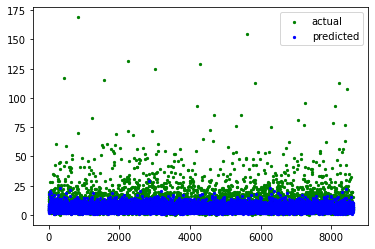

In [110]:
yhat_train_text = m_text.predict(x_train)
yhat_test_text = m_text.predict(x_test)
plt.scatter(range(len(y_train)), y_train, s = 5 , color = 'g', label = 'actual')
plt.scatter(range(len(y_train)), yhat_train_text, s=5, color = 'b', label ='predicted')
plt.legend(loc = 1)
print('\nRsquared score on train is:',r2_score(y_train, yhat_train_text))
print('\nRsquared score on test is:',r2_score(y_test, yhat_test_text))
print('\nActual output:\n', y_train[:5])
print('\nPredicted output:\n', yhat_train_text[:5])
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(range(len(m_text_history.history['val_loss'])),m_text_history.history['val_loss'],'-o', label = 'val_loss')
plt.plot(range(len(m_text_history.history['loss'])),m_text_history.history['loss'],'-o', label = 'train_loss')
plt.legend(loc = 1, fontsize = 10)
plt.ylabel('MSE'), plt.title('DNN: Text data')
plt.subplot(2,1,2)
plt.plot(range(len(m_text_history.history['val_mae'])),m_text_history.history['val_mae'],'-o', label = 'validation MAE')
plt.plot(range(len(m_text_history.history['mae'])),m_text_history.history['mae'],'-o', label = 'train MAE')
plt.legend(loc = 1, fontsize = 10)
plt.ylabel('MAE')
plt.show()

#### RNN : Text only

In [34]:
embedding_size = 250

nlp_input = Input(shape=(max_sequence,))
emb = Embedding(max_words, embedding_size, input_length = max_sequence)(nlp_input)  # text input layer
l1 = Dense(100, activation = 'elu')(emb)
nl2 = LSTM(100, activation = 'relu', kernel_initializer = 'glorot_uniform', return_sequences=True)(l1)
d1 = Dropout(0.2)(nl2)
nl3 = LSTM(50, activation = 'relu', kernel_initializer = 'glorot_uniform', return_sequences=True)(d1)
d2 = Dropout(0.2)(nl3)
nl4 = LSTM(50, activation = 'tanh', dropout = 0.2, recurrent_dropout = 0.15, return_sequences = True)(d2)
nl5 = GRU(50, activation = 'relu', recurrent_activation = 'tanh')(nl4)

output = Dense(1, activation = "linear")(nl5)

rnn_text = Model(inputs = [nlp_input], outputs = [output])
rnn_text.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 300)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 300, 250)          12500000  
_________________________________________________________________
dense_21 (Dense)             (None, 300, 100)          25100     
_________________________________________________________________
lstm_20 (LSTM)               (None, 300, 100)          80400     
_________________________________________________________________
dropout_21 (Dropout)         (None, 300, 100)          0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 300, 50)           30200     
_________________________________________________________________
dropout_22 (Dropout)         (None, 300, 50)           0   

In [35]:
solver = optimizers.Adam(learning_rate = 1)
callback = EarlyStopping(monitor='val_loss', patience=5)
rnn_text.compile(optimizer = solver,loss = 'mse', metrics = ['mae','mse'])
rnn_text_history = rnn_text.fit(x_train, y_train, batch_size = 100, epochs = 1, validation_split = 0.2, callbacks = [callback])

C:\Users\stan\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6890 samples, validate on 1723 samples
Epoch 1/1
6890/6890 [==============================] - 276s 40ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


c:\users\stan\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks\callbacks.py:820: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


In [ ]:
yhat_train_rnn_text = rnn_text.predict(x_train)
yhat_test_rnn_text = rnn_text.predict(x_test)
plt.scatter(x_train[:,1], y_train, s = 5 , color = 'g', label = 'actual')
plt.scatter(x_train[:,1], yhat_train_rnn_text, s=5, color = 'b', label ='predicted')
plt.legend(loc = 1)
print('\nRsquared score on train is:',r2_score(y_train, yhat_train_rnn_text))
print('\nRsquared score on test is:',r2_score(y_test, yhat_test_rnn_text))
print('\nActual output:\n', y_train[:5])
print('\nPredicted output:\n', yhat_train_rnn_text[:5])
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(range(len(rnn_text_history.history['val_loss'])),rnn_text_history.history['val_loss'],'-o', label = 'val_loss')
plt.plot(range(len(rnn_text_history.history['loss'])),rnn_text_history.history['loss'],'-o', label = 'train_loss')
plt.legend(loc = 1, fontsize = 10)
plt.ylabel('MSE'), plt.title('RNN : Text data')
plt.subplot(2,1,2)
plt.plot(range(len(rnn_text_history.history['val_mae'])),rnn_text_history.history['val_mae'],'-o', label = 'validation MAE')
plt.plot(range(len(rnn_text_history.history['mae'])),rnn_text_history.history['mae'],'-o', label = 'train MAE')
plt.legend(loc = 1, fontsize = 10)
plt.ylabel('MAE')
plt.show()

#### RNN : Text & DNN : Numeric

In [ ]:
embedding_size = 100

'''Sequential model'''
m = Sequential() 

'''Numeric input layer'''
num_input = Input(shape = (10, ))
numl = Dense(100, activation = 'relu')(num_input)
dl = Dropout(0.2)(numl)

'''Text input layer'''
nlp_input = Input(shape=(max_sequence,))
emb = Embedding(max_words, embedding_size, input_length = max_sequence)(nlp_input)  # text input layer
nl2 = LSTM(200, activation = 'tanh', kernel_initializer = 'glorot_uniform', return_sequences=True)(emb)
d1 = Dropout(0.2)(nl2)
nl3 = LSTM(100, activation = 'tanh', kernel_initializer = 'glorot_uniform', return_sequences=True)(d1)
d2 = Dropout(0.2)(nl3)
nl4 = LSTM(50, activation = 'tanh', dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True)(d2)
nl5 = GRU(50, activation = 'tanh', recurrent_activation = 'tanh')(nl4)

merge = concatenate([dl, nl5])   # merge Dense and LSTM layers

output = Dense(1, activation = "linear")(merge)

m = Model(inputs = [num_input, nlp_input], outputs = [output])

m.summary()

In [ ]:
solver = optimizers.Adam(learning_rate = 1)
callback = EarlyStopping(monitor='val_loss', patience=5)
m.compile(optimizer = solver,loss = 'mae', metrics = ['mae','mse'])
history = m.fit([z_train, x_train], y_train, batch_size = 100, epochs = 1, validation_split = 0.2, callbacks = [callback])

In [ ]:
yhat_train = m.predict([z_train, x_train])
yhat_test = m.predict([z_test, x_test])
print('Rsquared score on train is:',r2_score(y_train, yhat_train))
print('Rsquared score on test is:',r2_score(y_test, yhat_test))
plt.scatter(z_train[:,1], y_train, s = 5 , color = 'g', label = 'actual')
plt.scatter(z_train[:,1], yhat_train, s=5, color = 'b', label ='predicted')
plt.legend(loc = 1)
plt.show()

In [ ]:
Weights = []
for layer in m.layers:
    Weights.append({layer : layer.get_weights()})
Weights